In [1]:
#เชื่อม google drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import zipfile
import os

# กำหนด path ไปยังโฟลเดอร์ใน Drive
drive_folder = '/content/drive/MyDrive/dataset_aibuilders_2'

# รายชื่อไฟล์ zip ที่จะโหลด
zip_files = ['Salmon.zip', 'Trout.zip']

# โฟลเดอร์ปลายทาง
extract_folder = '/content/dataset'

# สร้างโฟลเดอร์ปลายทางถ้ายังไม่ได้สร้าง
os.makedirs(extract_folder, exist_ok=True)

# โหลดแล้วแตกไฟล์ zip ทีละอัน
for zip_name in zip_files:
    zip_path = os.path.join(drive_folder, zip_name)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_folder)
        print(f'แตกไฟล์ {zip_name} เสร็จแล้วอยู่ที่ {extract_folder}')


แตกไฟล์ Salmon.zip เสร็จแล้วอยู่ที่ /content/dataset
แตกไฟล์ Trout.zip เสร็จแล้วอยู่ที่ /content/dataset


In [14]:
import torch
import torchvision
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, Subset, random_split
from sklearn.model_selection import KFold
import numpy as np
import os
import random
import copy
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score


In [4]:
# Train: มี Augmentation
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Validation / Test: ไม่มีการสุ่ม
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [5]:
!mv /content/dataset/s /content/dataset/Salmon
!mv /content/dataset/t /content/dataset/Trout


In [6]:
from sklearn.model_selection import train_test_split

# Seed สำหรับ reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# โหลด dataset
full_dataset = datasets.ImageFolder('/content/dataset')
class_names = full_dataset.classes
print("Classes:", class_names)

# แยก test set 20% แบบ stratified
targets = [s[1] for s in full_dataset.samples]
train_val_idx, test_idx = train_test_split(
    list(range(len(full_dataset))),
    test_size=0.2,
    stratify=targets,
    random_state=seed
)

# แบ่ง dataset
train_val_dataset = Subset(full_dataset, train_val_idx)
test_dataset = Subset(full_dataset, test_idx)

# ใส่ transform สำหรับ test
test_dataset.dataset.transform = val_test_transform


Classes: ['Salmon', 'Trout']


In [7]:
import torch
from torch.utils.data import DataLoader, Subset
from torchvision import transforms, models
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

seed = 42
kfold = KFold(n_splits=5, shuffle=True, random_state=seed)

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# สำหรับเก็บค่า loss และ accuracy
train_losses_all = []
val_losses_all = []
val_acc_all = []
test_acc_all = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(train_val_dataset)):
    print(f"\nFold {fold+1}")

    train_subset = Subset(train_val_dataset, train_idx)
    val_subset = Subset(train_val_dataset, val_idx)

    train_subset.dataset.transform = train_transform
    val_subset.dataset.transform = val_test_transform

    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    model = models.resnet34(pretrained=True)
    model.fc = torch.nn.Linear(model.fc.in_features, len(class_names))
    model = model.to(device)

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    train_losses = []
    val_losses = []

    for epoch in range(10):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)

        # คำนวณ validation loss
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        avg_val_loss = val_loss / len(val_loader)

        train_losses.append(avg_loss)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/10 - Train Loss: {avg_loss:.4f} - Val Loss: {avg_val_loss:.4f}")

    # เก็บ loss สำหรับ plot
    train_losses_all.append(train_losses)
    val_losses_all.append(val_losses)

    # Validation Accuracy
    model.eval()
    correct_val, total_val = 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)
    val_acc = 100 * correct_val / total_val
    val_acc_all.append(val_acc)
    print(f"Fold {fold+1} Validation Accuracy: {val_acc:.2f}%")

    # Test Accuracy
    correct_test, total_test = 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct_test += (preds == labels).sum().item()
            total_test += labels.size(0)
    test_acc = 100 * correct_test / total_test
    test_acc_all.append(test_acc)
    print(f"Fold {fold+1} Test Accuracy: {test_acc:.2f}%")

    # Save model
    torch.save(model.state_dict(), f'resnet34_fold{fold+1}.pth')
    print(f"Model for Fold {fold+1} saved as resnet34_fold{fold+1}.pth")


Using device: cuda

Fold 1


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 173MB/s]


Epoch 1/10 - Train Loss: 0.8499 - Val Loss: 9.2383
Epoch 2/10 - Train Loss: 0.3785 - Val Loss: 39.5664
Epoch 3/10 - Train Loss: 0.1499 - Val Loss: 3.7096
Epoch 4/10 - Train Loss: 0.1118 - Val Loss: 1.0715
Epoch 5/10 - Train Loss: 0.1165 - Val Loss: 1.1567
Epoch 6/10 - Train Loss: 0.0975 - Val Loss: 0.2961
Epoch 7/10 - Train Loss: 0.0688 - Val Loss: 0.3138
Epoch 8/10 - Train Loss: 0.1285 - Val Loss: 0.8297
Epoch 9/10 - Train Loss: 0.1245 - Val Loss: 0.4511
Epoch 10/10 - Train Loss: 0.1663 - Val Loss: 0.3046
Fold 1 Validation Accuracy: 83.64%
Fold 1 Test Accuracy: 83.82%
Model for Fold 1 saved as resnet34_fold1.pth

Fold 2
Epoch 1/10 - Train Loss: 0.7736 - Val Loss: 13.3360
Epoch 2/10 - Train Loss: 0.3867 - Val Loss: 155.1557
Epoch 3/10 - Train Loss: 0.2562 - Val Loss: 16.0934
Epoch 4/10 - Train Loss: 0.1872 - Val Loss: 1.9266
Epoch 5/10 - Train Loss: 0.1721 - Val Loss: 2.0735
Epoch 6/10 - Train Loss: 0.1645 - Val Loss: 2.6733
Epoch 7/10 - Train Loss: 0.1819 - Val Loss: 0.3271
Epoch 8/10

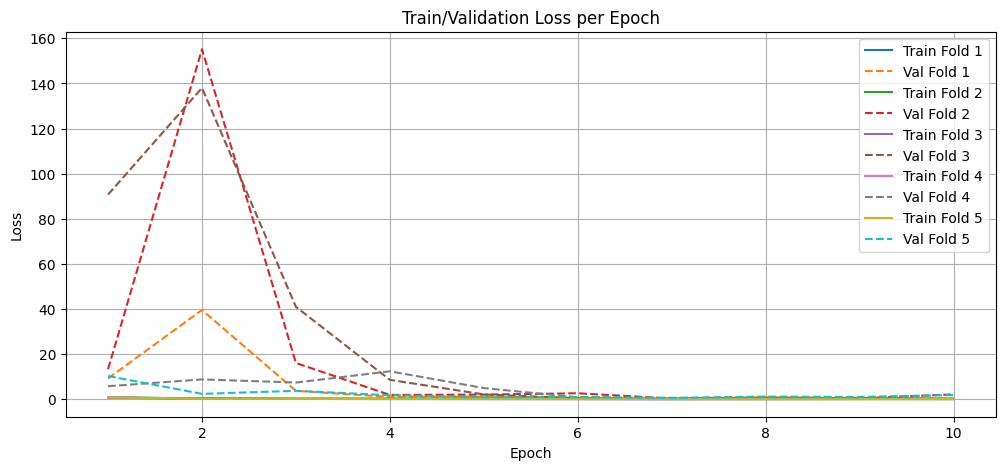

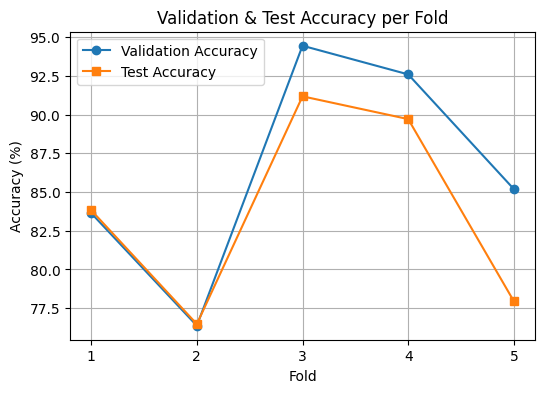

In [8]:
# Plot graph
plt.figure(figsize=(12, 5))
for fold in range(5):
    plt.plot(range(1, 11), train_losses_all[fold], label=f'Train Fold {fold+1}')
    plt.plot(range(1, 11), val_losses_all[fold], '--', label=f'Val Fold {fold+1}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train/Validation Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(range(1, 6), val_acc_all, marker='o', label='Validation Accuracy')
plt.plot(range(1, 6), test_acc_all, marker='s', label='Test Accuracy')
plt.xlabel('Fold')
plt.ylabel('Accuracy (%)')
plt.title('Validation & Test Accuracy per Fold')
plt.xticks(range(1, 6))
plt.legend()
plt.grid(True)
plt.show()



===== Evaluation for Fold 1 =====


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Loss: 0.4903
Accuracy: 0.8382
Precision (macro): 0.8457
Recall (macro): 0.8382
F1-score (macro): 0.8374

Classification Report:
              precision    recall  f1-score   support

      Salmon       0.79      0.91      0.85        34
       Trout       0.90      0.76      0.83        34

    accuracy                           0.84        68
   macro avg       0.85      0.84      0.84        68
weighted avg       0.85      0.84      0.84        68



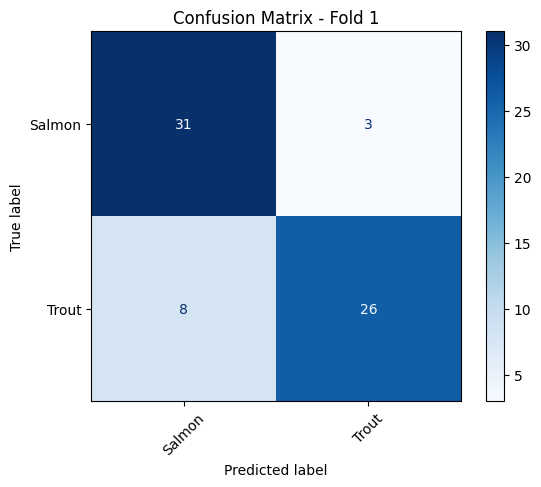


===== Evaluation for Fold 2 =====


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Loss: 1.4867
Accuracy: 0.7647
Precision (macro): 0.8400
Recall (macro): 0.7647
F1-score (macro): 0.7509

Classification Report:
              precision    recall  f1-score   support

      Salmon       0.68      1.00      0.81        34
       Trout       1.00      0.53      0.69        34

    accuracy                           0.76        68
   macro avg       0.84      0.76      0.75        68
weighted avg       0.84      0.76      0.75        68



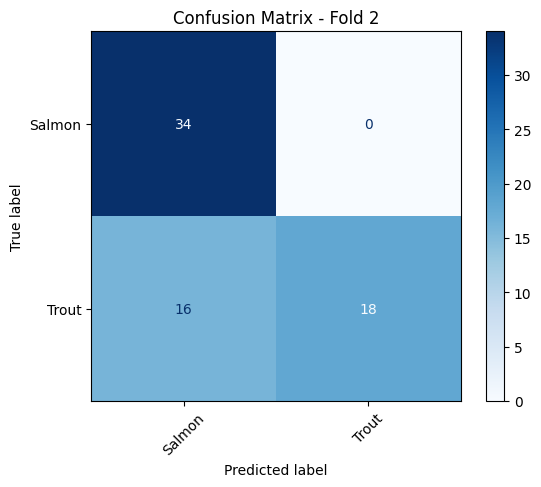


===== Evaluation for Fold 3 =====


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Loss: 0.2591
Accuracy: 0.9118
Precision (macro): 0.9132
Recall (macro): 0.9118
F1-score (macro): 0.9117

Classification Report:
              precision    recall  f1-score   support

      Salmon       0.89      0.94      0.91        34
       Trout       0.94      0.88      0.91        34

    accuracy                           0.91        68
   macro avg       0.91      0.91      0.91        68
weighted avg       0.91      0.91      0.91        68



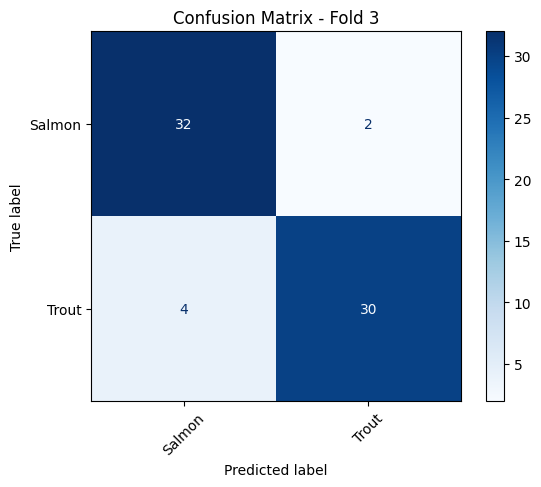


===== Evaluation for Fold 4 =====


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Loss: 0.2619
Accuracy: 0.8971
Precision (macro): 0.9058
Recall (macro): 0.8971
F1-score (macro): 0.8965

Classification Report:
              precision    recall  f1-score   support

      Salmon       0.97      0.82      0.89        34
       Trout       0.85      0.97      0.90        34

    accuracy                           0.90        68
   macro avg       0.91      0.90      0.90        68
weighted avg       0.91      0.90      0.90        68



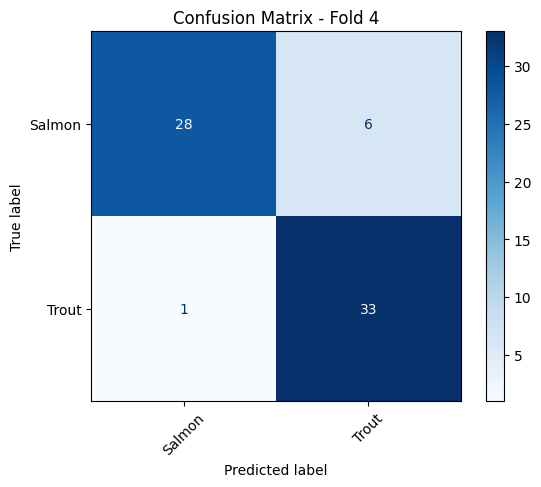


===== Evaluation for Fold 5 =====


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Loss: 2.0076
Accuracy: 0.7794
Precision (macro): 0.8121
Recall (macro): 0.7794
F1-score (macro): 0.7735

Classification Report:
              precision    recall  f1-score   support

      Salmon       0.91      0.62      0.74        34
       Trout       0.71      0.94      0.81        34

    accuracy                           0.78        68
   macro avg       0.81      0.78      0.77        68
weighted avg       0.81      0.78      0.77        68



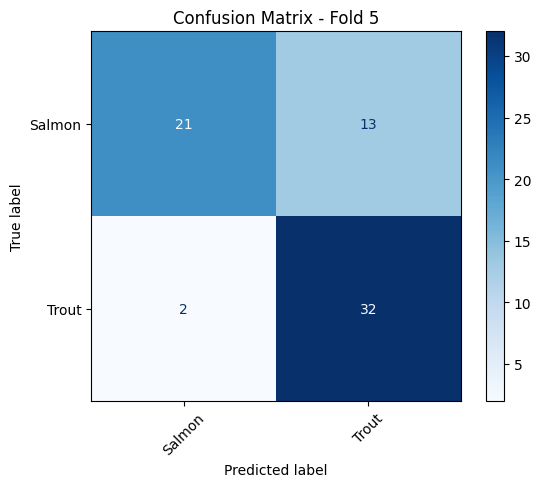

In [15]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

class_names = {0: "Salmon", 1: "Trout"}
class_names_list = [class_names[i] for i in sorted(class_names.keys())]

criterion = torch.nn.CrossEntropyLoss()

for fold, (train_idx, val_idx) in enumerate(kfold.split(train_val_dataset)):
    print(f"\n===== Evaluation for Fold {fold+1} =====")

    # Load model
    model = models.resnet34(pretrained=False)
    model.fc = torch.nn.Linear(model.fc.in_features, len(class_names_list))
    model.load_state_dict(torch.load(f'resnet34_fold{fold+1}.pth'))
    model = model.to(device)
    model.eval()

    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    all_preds = []
    all_labels = []
    all_losses = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            all_losses.append(loss.item())

            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = np.mean(all_losses)
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

    print(f"Loss: {avg_loss:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (macro): {precision:.4f}")
    print(f"Recall (macro): {recall:.4f}")
    print(f"F1-score (macro): {f1:.4f}")

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names_list, zero_division=0))

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names_list)
    disp.plot(xticks_rotation=45, cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix - Fold {fold+1}")
    plt.show()


Saving Screenshot 2025-05-08 121815.png to Screenshot 2025-05-08 121815.png


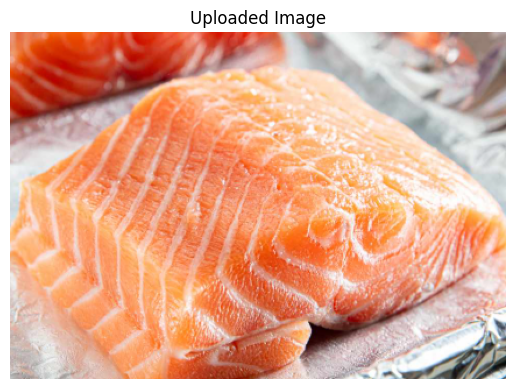

Predicted Class: 0 => Salmon


In [11]:
import torch
import torchvision.transforms as transforms
from PIL import Image
from torchvision import models
import torch.nn as nn
import matplotlib.pyplot as plt

# ตั้งค่าอุปกรณ์
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class_names = {0: "Salmon", 1: "Trout"}

# โหลดโมเดล (ให้ใช้ ResNet รเดียวกับตอนเทรน)
model = models.resnet34(weights=None)
model.fc = nn.Linear(model.fc.in_features, 2)  # เปลี่ยน output ตามที่ใช้ตอนเทรน
model.load_state_dict(torch.load("/content/resnet34_fold3.pth", map_location=device))
model = model.to(device)
model.eval()

# Transform เหมือนตอน train
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],  # ถ้าใช้ ImageNet pretrained
                         [0.229, 0.224, 0.225])
])

# ฟังก์ชันอัปโหลดรูปและทำนาย
from google.colab import files

uploaded = files.upload()
for filename in uploaded.keys():
    # โหลดและแปลงภาพ
    image = Image.open(filename).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)

    # พล็อตภาพ
    plt.imshow(image)
    plt.axis("off")
    plt.title("Uploaded Image")
    plt.show()

    # ทำนาย
    with torch.no_grad():
        outputs = model(input_tensor)
        _, predicted = torch.max(outputs, 1)
        print(f"Predicted Class: {predicted.item()} => {class_names[predicted.item()]}")
